## Example 1: Degenerate Markov Chain

#### Overview

We explore a case where **different parameterizations lead to the same stochastic dynamics**. Both systems are **conservative**:

$$X_1 + X_2 = \text{constant}$$

For a total count of 2, the systems produce **identical stochastic transitions**.

---

### System 1: Simple Reversible
$$
X_1 \xrightarrow{k_1 = 1} X_2, \quad X_2 \xrightarrow{k_2 = 1} X_1
$$

The reaction propensities are as follows:
$$
a_1(X_1, X_2) = k_1 \cdot X_1 = X_1, \quad a_2(X_1, X_2) = k_2 \cdot X_2 = X_2
$$

---

### System 2: Bimolecular Intermediate

$$
2 X_1 \xrightarrow{\lambda_1 = 2} X_1 + X_2, \quad 
X_1 + X_2 \xrightarrow{\lambda_2 = 1} 2 X_1, \quad 
X_1 + X_2 \xrightarrow{\lambda_3 = 1} 2 X_2, \quad 
2 X_2 \xrightarrow{\lambda_4 = 2} X_1 + X_2
$$

The reaction propensities are as follows:
$$
a_1(X_1) =   \frac{\lambda_1 X_1 (X_1 - 1)}{2} = X_1 (X_1-1), \quad 
a_2(X_1, X_2) = \lambda_2 \cdot X_1 X_2 = X_1 (X_2), \quad 
a_3(X_1, X_2) = \lambda_3 \cdot X_1 X_2 = X_1 (X_2), \quad 
a_4(X_2) = \frac{\lambda_4  X_2 (X_2 - 1)}{2} = X_2 (X_2-1)
$$

---

### Allowed States and Transitions (Total = 2)

| Current State $(X_1, X_2)$ | Stochiometric Change $(\Delta X_1, \Delta X_2)$| System 1 Propensity | System 2 Propensity |
|-------------------------------|----------------------------------------------------|-------------------|-------------------|
| (2,0)                         | (-1,1)      | $k_1 \cdot 2 = 2$ | $\lambda_1 \cdot \frac{2 \cdot (2-1)}{2} = 2$ |
| (1,1)                         | (-1,1)      | $k_1 \cdot 1 = 1$ | $\lambda_3 \cdot 1 \cdot 1 = 1$ |
| (1,1)                         | (1,-1)      | $k_2 \cdot 1 = 1$ | $\lambda_2 \cdot 1 \cdot 1 = 1$ |
| (0,2)                         | (1,-1)      | $k_2 \cdot 2 = 2$ | $\lambda_4 \cdot \frac{2 \cdot (2-1)}{2} = 2$|

---

✅ **Observation:** Both systems produce **the same stochastic transitions and propensities** for all states with total population 2, despite having **different reaction structures and rate constants**. This illustrates the **degeneracy / non-identifiability** in this Markov system.


In [1]:
import sys
import os

# Add repo root to Python path (one level up from examples/)
sys.path.append(os.path.abspath(".."))  

from src.parsing import *
from src.inference import *
from CRN_Simulation.CRN import CRN

import numpy as np
import random

In [2]:
# Determine Stochiometric, Reactant and names of reactions
species_names = ["X1", "X2"]

# Define complexes (example: bi-molecular)
complexes = np.array([[0, 0, 0, 1, 1, 2],
                      [0, 1, 2, 0, 1, 0]])

# Create Reactant, Product, Stochiometric Matrix, Define Compatible Reactions and Everything Needed for CRN
reactant_matrix, product_matrix, stoichiometric_matrix, reaction_names, parameter_names, compatible_reactions = generate_reactions(complexes, species_names)

# Plot some output to the screen
print(f"Total reactions generated: {len(reaction_names)}")
max_show = 3
print("Some Reaction Names:", reaction_names[:max_show])

print("Some Non-Unique Stoichiometric Changes")
count_shown = 0
for deltaX, rxn_indices in compatible_reactions.items():
    if len(rxn_indices) > 1:
        deltaX_clean = tuple(int(x) for x in deltaX)
        # Grab all reaction names
        rxn_names = [reaction_names[i] for i in rxn_indices]
        print(f"ΔX = {deltaX_clean} → indices: {rxn_indices}, reactions: {rxn_names}")
        count_shown += 1
        if count_shown >= max_show:
            break

Total reactions generated: 30
Some Reaction Names: ['Empty_to_X2:', 'Empty_to_2X2:', 'Empty_to_X1:']
Some Non-Unique Stoichiometric Changes
ΔX = (0, 1) → indices: [0, 6, 18], reactions: ['Empty_to_X2:', 'X2_to_2X2:', 'X1_to_X1+X2:']
ΔX = (1, 0) → indices: [2, 8, 19], reactions: ['Empty_to_X1:', 'X2_to_X1+X2:', 'X1_to_2X1:']
ΔX = (0, -1) → indices: [5, 11, 23], reactions: ['X2_to_Empty:', '2X2_to_X2:', 'X1+X2_to_X1:']


In [3]:
############################
# Set up Reaction System 1 #
############################
reactions_sys1 = ["X1_to_X2", "X2_to_X1"] # X1->X2; X2->X1
rates_sys1     = [1, 1]                   # X1->X2; X2->X1


############################
# Set up Reaction System 2 #
############################
reactions_sys2 = ["2X1_to_X1+X2", "X1+X2_to_2X1","X1+X2_to_2X2","2X2_to_X1+X2"] # 2X1->X1+X2; X1+X2->2X1; X1+X2->2X2; 2X2->X1+X2
rates_sys2     = [2, 1, 1, 2] # 2X1->X1+X2; X1+X2->2X1; X1+X2->2X2; 2X2->X1+X2 

In [4]:
############################
# Generate CRN System 1
############################
(CRN1_stoichiometric_matrix,
 CRN1_reaction_names,
 CRN1_parameter_names,
 CRN1_propensities,
 CRN1_parameter_values,
 CRN1_indices) = build_subCRN_from_names(
    reactant_matrix,
    product_matrix,
    stoichiometric_matrix,
    reaction_names,
    parameter_names,
    species_names,
    selected_names=reactions_sys1,
    rates=rates_sys1
)

rn1 = CRN(
    species_names=species_names,
    stoichiometric_matrix=CRN1_stoichiometric_matrix,
    parameters_names=CRN1_parameter_names,
    reaction_names=CRN1_reaction_names,
    propensities=CRN1_propensities
)

print("CRN1 created.")
print("Reaction indices:", CRN1_indices)
print("Parameter values:", CRN1_parameter_values)
print("***********")

############################
# Generate CRN System 2
############################
(CRN2_stoichiometric_matrix,
 CRN2_reaction_names,
 CRN2_parameter_names,
 CRN2_propensities,
 CRN2_parameter_values,
 CRN2_indices) = build_subCRN_from_names(
    reactant_matrix,
    product_matrix,
    stoichiometric_matrix,
    reaction_names,
    parameter_names,
    species_names,
    selected_names=reactions_sys2,
    rates=rates_sys2
)

rn2 = CRN(
    species_names=species_names,
    stoichiometric_matrix=CRN2_stoichiometric_matrix,
    parameters_names=CRN2_parameter_names,
    reaction_names=CRN2_reaction_names,
    propensities=CRN2_propensities
)

print("CRN2 created.")
print("Reaction indices:", CRN2_indices)
print("Parameter values:", CRN2_parameter_values)

CRN1 created.
Reaction indices: [16, 7]
Parameter values: {'k16': 1, 'k7': 1}
***********
CRN2 created.
Reaction indices: [29, 24, 22, 13]
Parameter values: {'k29': 2, 'k24': 1, 'k22': 1, 'k13': 2}


Initial state: {'X1': np.int64(1), 'X2': np.int64(1)}
Trajectory saved to ../data/example1_crn1_trajectory.json
CRN1 trajectory saved to ../data/example1_crn1_trajectory.json
Initial state: {'X1': np.int64(1), 'X2': np.int64(1)}
Trajectory saved to ../data/example2_crn2_trajectory.json
CRN2 trajectory saved to ../data/example2_crn2_trajectory.json


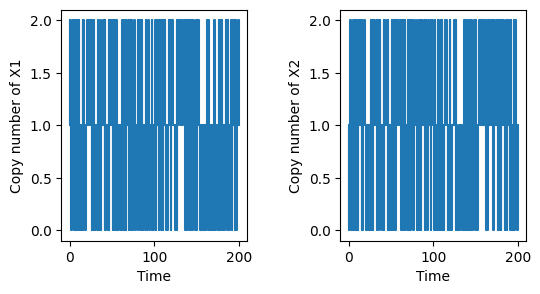

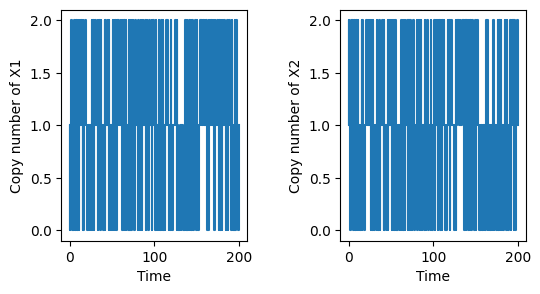

In [14]:
data_dir = "../data"  # relative to examples/ folder
os.makedirs(data_dir, exist_ok=True)

############################
# Generate trajectory for CRN1
############################
time_list1, state_list1 = generate_single_trajectory(
    rn1,
    CRN1_parameter_values,
    species_names,
    finalTime=200,   # adjust as needed
    minVal=1,
    maxVal=1,
    seed=42          # for reproducibility
)

trajectory_file1 = os.path.join(data_dir, "example1_crn1_trajectory.json")
save_trajectory(time_list1, state_list1, filename=trajectory_file1)
print(f"CRN1 trajectory saved to {trajectory_file1}")


############################
# Generate trajectory for CRN2
############################
time_list2, state_list2 = generate_single_trajectory(
    rn2,
    CRN2_parameter_values,
    species_names,
    finalTime=200,   # adjust as needed
    minVal=1,
    maxVal=1,
    seed=42          # reproducibility
)

trajectory_file2 = os.path.join(data_dir, "example2_crn2_trajectory.json")
save_trajectory(time_list2, state_list2, filename=trajectory_file2)
print(f"CRN2 trajectory saved to {trajectory_file2}")

In [6]:
# Parse trajectories for CRN1
print("Parsing trajectory for CRN1")
unique_changes1, unique_states1, jump_counts1, waiting_times1, propensities1 = parse_trajectory(
    state_list1,time_list1,reactant_matrix,compatible_reactions,verbose=True)
print("---------")

# Parse trajectories for CRN2
print("Parsing trajectory for CRN2")
unique_changes2, unique_states2, jump_counts2, waiting_times2, propensities2 = parse_trajectory(
    state_list2, time_list2, reactant_matrix, compatible_reactions, verbose=True)
print("---------")

# Print basic summary
print("Finished parsing trajectories. Summary:")
print(f"CRN1: {len(unique_states1)} unique states observed")
print(f"CRN2: {len(unique_states2)} unique states observed")

Parsing trajectory for CRN1
Tracking 18 unique stoichiometric changes (single trajectory).
Trajectory length: 366 timepoints.  Will iterate to len-2 to avoid final non-jump.
Finished parsing single trajectory. Observed 3 unique states.
---------
Parsing trajectory for CRN2
Tracking 18 unique stoichiometric changes (single trajectory).
Trajectory length: 366 timepoints.  Will iterate to len-2 to avoid final non-jump.
Finished parsing single trajectory. Observed 3 unique states.
---------
Finished parsing trajectories. Summary:
CRN1: 3 unique states observed
CRN2: 3 unique states observed


In [7]:
print("Jump counts keys:", jump_counts1.keys())
print("Waiting times keys:", waiting_times1.keys())
print("Propensities keys:", propensities1.keys())

Jump counts keys: dict_keys([(1, 1), (2, 0), (0, 2)])
Waiting times keys: dict_keys([(1, 1), (2, 0), (0, 2)])
Propensities keys: dict_keys([(1, 1), (2, 0), (0, 2)])


In [8]:
indexToCheck = 6
deltaXToCheck = None
(local_counts, local_waiting_times, local_propensities, selected_deltaX) = extract_local_data(
    jump_counts1, waiting_times1, propensities1, unique_changes1, index=indexToCheck, deltaX=deltaXToCheck, verbose=True)

Extracting local data for stoichiometric change [1, -1] at index 6
✅ All states processed successfully — no empty propensities, consistent lengths, no negative counts, all waiting times valid.
Local data extraction complete. 3 states processed.


In [9]:
unique_states1

[(1, 1), (2, 0), (0, 2)]

In [10]:
print(jump_counts1)

defaultdict(<function parse_trajectory.<locals>.<lambda> at 0x11297a8b0>, {(1, 1): array([ 0,  0,  0,  0,  0,  0, 92,  0,  0,  0,  0,  0, 90,  0,  0,  0,  0,
        0]), (2, 0): array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 92,  0,  0,  0,  0,
        0]), (0, 2): array([ 0,  0,  0,  0,  0,  0, 90,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0])})


In [11]:
local_log_likelihood(local_counts,local_waiting_times,local_propensities,[0,.1,1])

np.float64(-267.9074409598167)

In [12]:
local_counts

{(1, 1): np.int64(92), (2, 0): np.int64(0), (0, 2): np.int64(90)}

In [13]:
local_propensities

{(1, 1): array([1., 0., 1.]),
 (2, 0): array([0., 0., 0.]),
 (0, 2): array([2., 1., 0.])}